Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t0_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t25_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t50_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t75_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t100_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t125_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t150_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t175_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t200_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t225_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t250_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t275_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t3

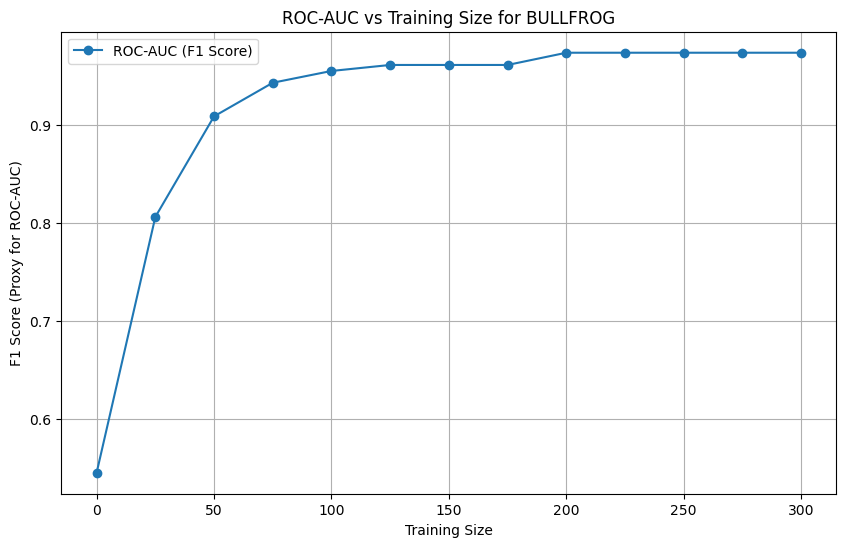

In [10]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

# Function to extract training size from filename
def extract_training_size(filename):
    match = re.search(r'_t(\d+)_', filename)
    return int(match.group(1)) if match else None

# Load the key data
key_df = pd.read_csv('results-Bullfrog/bullfrog_key.csv')
if 'Begin Time (s)' in key_df.columns:
    key_df = key_df.rename(columns={'Begin Time (s)': 'begin_time_s'})

# Define file patterns
base_path = 'results-Bullfrog/bullfrog_birdnetv2.4_t{}_e50_b32_l0.001.txt'
results_patterns = [base_path.format(t) for t in range(0, 301, 25)]  # Max training size is 300

# Initialize an empty DataFrame to store combined results from all files
merged_table = key_df[['begin_time_s']].drop_duplicates()

# Process each training size file
for pattern in results_patterns:
    if os.path.exists(pattern):
        print(f"Processing file: {pattern}")
        
        # Extract training size
        training_size = extract_training_size(pattern)
        
        # Load BirdNet results
        results_df = pd.read_csv(pattern, delimiter='\t')
        
        # Rename columns for consistency
        if 'Begin Time (s)' in results_df.columns:
            results_df = results_df.rename(columns={'Begin Time (s)': 'begin_time_s'})
        
        # Merge with key data
        joined_df = pd.merge(results_df, key_df, on='begin_time_s', how='outer', indicator=True)
        
        # Calculate TP, FN, FP, TN for this training size
        joined_df['tp'] = ((joined_df['Annotation'] == 'BULLFROG') & 
                           (joined_df['label'] == 1) & 
                           (joined_df['_merge'] == 'both')).astype(int)
        joined_df['fn'] = ((joined_df['Annotation'] == 'BULLFROG') & 
                           (joined_df['label'] == 1) & 
                           (joined_df['_merge'] == 'right_only')).astype(int)
        joined_df['tn'] = ((joined_df['Annotation'].isna()) & 
                           (joined_df['label'] == 0) & 
                           (joined_df['_merge'] == 'right_only')).astype(int)
        joined_df['fp'] = ((joined_df['Annotation'].isna()) & 
                           (joined_df['label'] == 0) & 
                           (joined_df['_merge'] == 'both')).astype(int)
        
        # Add columns for this training size
        joined_df[f'tp_t_{training_size}'] = joined_df['tp']
        joined_df[f'fn_t_{training_size}'] = joined_df['fn']
        joined_df[f'fp_t_{training_size}'] = joined_df['fp']
        joined_df[f'tn_t_{training_size}'] = joined_df['tn']
        
        # Keep only relevant columns for merging
        training_columns = [f'tp_t_{training_size}', f'fn_t_{training_size}', f'fp_t_{training_size}', f'tn_t_{training_size}']
        training_data = joined_df[['begin_time_s'] + training_columns].drop_duplicates()
        
        # Merge with the main table
        merged_table = pd.merge(merged_table, training_data, on='begin_time_s', how='outer')
    else:
        print(f"File not found: {pattern}")

# Save the merged table
merged_table.to_csv('output/bullfrog_merged_table.csv', index=False)
print("Saved merged table to 'output/bullfrog_merged_table.csv'")

# Calculate metrics summary
metrics_summary = []
for training_size in range(0, 301, 25):
    tp = merged_table[f'tp_t_{training_size}'].fillna(0).sum()
    fn = merged_table[f'fn_t_{training_size}'].fillna(0).sum()
    fp = merged_table[f'fp_t_{training_size}'].fillna(0).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_summary.append({
        'training_size': training_size, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1_score
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv('output/bullfrog_metrics_summary.csv', index=False)
print("Saved metrics summary to 'output/bullfrog_metrics_summary.csv'")

# Plotting ROC-AUC (F1 Score as proxy)
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['training_size'], metrics_df['f1_score'], marker='o', label='ROC-AUC (F1 Score)')
plt.xlabel('Training Size')
plt.ylabel('F1 Score (Proxy for ROC-AUC)')
plt.title('ROC-AUC vs Training Size for BULLFROG')
plt.legend()
plt.grid(True)

# Save the plot
plot_path = 'output/bullfrog_roc_auc_plot.png'
plt.savefig(plot_path, format='png')
print(f"ROC-AUC plot saved to {plot_path}")

plt.show()



In [11]:
print(metrics_df)

    training_size  precision  recall  f1_score
0               0   0.531646    0.56  0.545455
1              25   0.675676    1.00  0.806452
2              50   0.833333    1.00  0.909091
3              75   0.892857    1.00  0.943396
4             100   0.914634    1.00  0.955414
5             125   0.925926    1.00  0.961538
6             150   0.925926    1.00  0.961538
7             175   0.925926    1.00  0.961538
8             200   0.949367    1.00  0.974026
9             225   0.949367    1.00  0.974026
10            250   0.949367    1.00  0.974026
11            275   0.949367    1.00  0.974026
12            300   0.949367    1.00  0.974026
